In [1]:
import numpy as np

BUILD PROBE VIA SITE MAP FROM NN
---

In [2]:
site_groups = {
    0: {
        'geometry':{
        },
        'sites': [x for x in range(1, 33)]  # 1 to 33
    },
    1: {
        'geometry': {
        },
        'sites': [x for x in range(33, 65)]  # 33 to 64
    }
}

In [3]:
row1 = np.arange(1, 7)
row2 = np.arange(7, 14)
row3 = np.array([14,19,15,18,16,17])
row4 = np.flipud(np.arange(20,27))
row5 = np.flipud(np.arange(27,33))
print (row1.size+row2.size+row3.size+row4.size+row5.size)

32


In [4]:
graph = []
last = None
for i in range(len(row1)):
    s1 = row1[i]
    if i>0:  # same row edge.
        graph.append((row1[i-1], s1))
    for ii in range(i, i+2):
        s2 = row2[ii]
        graph.append((s1,s2))
        
for i in range(len(row2)):
    s1 = row2[i]
    if i>0:  # same row edge.
        graph.append((row2[i-1], s1))
    for ii in range(i-1, i+1):
        if ii >= 0 and ii < len(row3):
            s2 = row3[ii]
            graph.append((s1,s2))
            
for i in range(len(row3)):
    s1 = row3[i]
    if i>0:  # same row edge.
        graph.append((row3[i-1], s1))
    for ii in range(i, i+2):
        s2 = row4[ii]
        graph.append((s1,s2))

for i in range(len(row4)):
    s1 = row4[i]
    if i>0:  # same row edge.
        graph.append((row4[i-1], s1))
    for ii in range(i-1, i+1):
        if ii >= 0 and ii < len(row5):
            s2 = row5[ii]
            graph.append((s1,s2))

for i in range(len(row5)-1):
    graph.append((row5[i], row5[i+1]))
site_groups[0]['graph'] = graph

In [5]:
graph2 = []
for i in graph:
    graph2.append([x+32 for x in i])
site_groups[1]['graph'] = graph2

In [6]:
geometry0 = {}
for i, s in enumerate(row1):
    geometry0[s] = (0, 14+28*i)
for i, s in enumerate(row2):
    geometry0[s] = (14*1, 28*i)
for i, s in enumerate(row3):
    geometry0[s] = (14*2, 14+28*i)
for i, s in enumerate(row4):
    geometry0[s] = (14*3, 28*i)
for i, s in enumerate(row5):
    geometry0[s] = (14*4, 14+28*i)
site_groups[0]['geometry'] = geometry0

geometry1 = {}
for s, v in geometry0.items():
    geometry1[s+32] = (v[0]+200, v[1])
site_groups[1]['geometry'] = geometry1

CONVERT TO CHANNELS FROM SITES
-----

In [7]:
SGL_64 = {
    'raw_channels': range(-1, 63),
    'Neuronexus': [
        50, 52, 59, 61, 56, 63, 58, 64, 34, 35, 62, 33, 60, 54, 57, 55, 10, 8, 11, 5, 32, 3, 30, 31, 1, 7, 2,
        9, 4, 6, 13, 15, 41, 43, 39, 40, 42, 44, 46, 48, 53, 51, 49, 47, 45, 36, 37, 38, 27, 28, 29, 20, 18,
        16, 14, 12, 17, 19, 21, 23, 25, 26, 22, 24
    ],
    'NanoZ': [
        34, 36, 38, 40, 42, 44, 46, 48, 47, 45, 43, 41, 39, 37, 35, 33, 57, 59, 62, 64, 50, 52, 54, 56, 55, 53,
        51, 49, 63, 61, 60, 58, 1, 3, 5, 7, 9, 11, 13, 15, 16, 14, 12, 10, 8, 6, 4, 2, 26, 28, 29, 31, 17, 19, 21,
        23, 24, 22, 20, 18, 32, 30, 27, 25
    ],
    'HIRES_4x16_flipchip': [
        18, 20, 21, 23, 24, 25, 26, 27, 31, 30, 29, 32, 28, 22, 19, 17, 48, 46, 43, 37, 33, 36, 35, 34, 38, 39, 40, 41,
        42, 44, 45, 47, 1, 3, 6, 8, 10, 12, 14, 16, 15, 13, 11, 9, 7, 5, 4, 2, 63, 61, 60, 58, 56, 54, 52, 50, 49, 51,
        53, 55, 57, 59, 62, 64
    ]
}

In [ ]:
SGL_64['Neuronexus'].index(55)

In [8]:
def convert_sites_to_channels(site_groups, acq_channels_numbers, acq_site_mapping):
    """
    This maps sites to channels for geometries and the site lists. Also checks for integrity of site lists.
    
    site_groups is a dictionary with sites and geometries keys.
    acq_channel_numbers is a list of channels in order from the acquistion system (ie a range from 0-63).
    acq_site_mapping is a list of site numbers corresponding to the acquisition channel numbers specified above.
    
    
    So this will map:
        site_groups {
            0: {
            'sites': [46,45,44]
            }
        }
        acq_channel_numbers = [1,2,3]
        acq_site_mapping = [45, 46, 46]
        
        to:
        site_groups {
            0: {
            'sites': [3, 2, 1]
            }
        }
    """
    all_ch = []
    for k, v in site_groups.items():
        all_ch.extend(v['sites'])
    print ("{0} sites found on all groups.".format(len(all_ch)))
    bad = False
    for i in all_ch:
        nmatches = 0
        for ii in all_ch:
            if ii == i:
                nmatches += 1
        if nmatches >= 2:
            print ("ERROR: duplicate site of number {0} found.".format(i))
            bad = True
    if bad:
        return None
    else:
        print ("No duplicate channels.")
        
    for k, v in site_groups.items():
        site_list = v['sites']
        geo = v['geometry'].keys()
        
        assert len(site_list) == len(geo)
        
        for s in site_list:
            if s not in geo:
                raise ValueError('Site {0} specified in "sites" but not in "geometry" for shank {1}'.format(s, k))
        for s in geo:
            if s not in site_list:
                raise ValueError('Site {0} specified in "geometry" but not "sites" for shank {1}'.format(s, k))        
    print('Site and geometry lists are congruent.')
    
    channel_groups = {}
    for g, v in site_groups.items():
        channel_group = {}
        channels = []
        geometry = {}
        for s in v['sites']:
            site_idx = acq_site_mapping.index(s)
            ch = acq_channels_numbers[site_idx]
            if ch > -1:
                channels.append(ch)
        channel_group['channels'] = channels
        
        for s, pos in v['geometry'].items():
            site_idx = acq_site_mapping.index(s)
            ch = acq_channels_numbers[site_idx]
            if ch > -1:
                geometry[ch] = pos
        channel_group['geometry'] = geometry
        
        graph = []
        for edge in v['graph']:
            new_edge = []
            for node in edge:
                new_edge.append(acq_channels_numbers[acq_site_mapping.index(node)])
            graph.append(new_edge)
        channel_group['graph'] = graph
        channel_groups[g] = channel_group
        
    return channel_groups

In [9]:
channel_groups = convert_sites_to_channels(site_groups, SGL_64['raw_channels'], SGL_64['Neuronexus'])

64 sites found on all groups.
No duplicate channels.
Site and geometry lists are congruent.


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

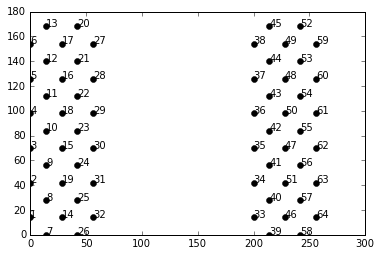

In [11]:
for k, v in site_groups.items():
    for kk, vv in v['geometry'].items():
        plt.plot(vv[0], vv[1], 'ko')
        plt.text(vv[0], vv[1], str(kk))

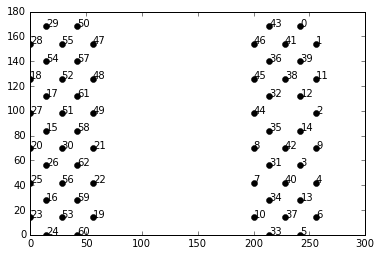

In [12]:
for k, v in channel_groups.items():
    for kk, vv in v['geometry'].items():
        plt.plot(vv[0], vv[1], 'ko')
        plt.text(vv[0], vv[1], str(kk))

In [21]:
print (channel_groups)

{0: {'graph': [[24, 25], [24, 17], [24, 26], [26, 17], [26, 27], [26, 21], [21, 27], [21, 16], [21, 28], [28, 16], [28, 18], [28, 19], [19, 18], [19, 55], [19, 29], [29, 55], [29, 30], [25, 54], [25, 17], [17, 54], [17, 57], [17, 27], [27, 57], [27, 31], [27, 16], [16, 31], [16, 52], [16, 18], [18, 52], [18, 53], [18, 55], [55, 53], [55, 56], [55, 30], [30, 56], [54, 61], [54, 60], [54, 57], [57, 60], [57, 63], [57, 31], [31, 63], [31, 59], [31, 52], [52, 59], [52, 62], [52, 53], [53, 62], [53, 58], [53, 56], [56, 58], [56, 51], [61, 20], [61, 60], [60, 20], [60, 23], [60, 63], [63, 23], [63, 22], [63, 59], [59, 22], [59, 50], [59, 62], [62, 50], [62, 49], [62, 58], [58, 49], [58, 48], [58, 51], [51, 48], [20, 23], [23, 22], [22, 50], [50, 49], [49, 48]], 'channels': [24, 26, 21, 28, 19, 29, 25, 17, 27, 16, 18, 55, 30, 54, 31, 53, 56, 52, 57, 51, 58, 62, 59, 63, 60, 61, 48, 49, 50, 22, 23, 20], 'geometry': {16: (14, 84), 17: (14, 28), 18: (14, 112), 19: (0, 126), 20: (56, 14), 21: (0, 

In [13]:
f = open('/home/cdw291/probes/whisper/A2x32-Poly5_whisper_spyking_missing_ch1.prb', 'w')
# pickle.dump(channel_groups, f, 0)
f.write("channel_groups = {0}".format(channel_groups.__str__()))
f.close()

In [22]:
channel_groups2 = {0: {'graph': [[24, 25], [24, 17], [24, 26], [26, 17], [26, 27], [26, 21], [21, 27], [21, 16], [21, 28], [28, 16], [28, 18], [28, 19], [19, 18], [19, 55], [19, 29], [29, 55], [29, 30], [25, 54], [25, 17], [17, 54], [17, 57], [17, 27], [27, 57], [27, 31], [27, 16], [16, 31], [16, 52], [16, 18], [18, 52], [18, 53], [18, 55], [55, 53], [55, 56], [55, 30], [30, 56], [54, 61], [54, 60], [54, 57], [57, 60], [57, 63], [57, 31], [31, 63], [31, 59], [31, 52], [52, 59], [52, 62], [52, 53], [53, 62], [53, 58], [53, 56], [56, 58], [56, 51], [61, 20], [61, 60], [60, 20], [60, 23], [60, 63], [63, 23], [63, 22], [63, 59], [59, 22], [59, 50], [59, 62], [62, 50], [62, 49], [62, 58], [58, 49], [58, 48], [58, 51], [51, 48], [20, 23], [23, 22], [22, 50], [50, 49], [49, 48]], 'geometry': {16: (14, 84), 17: (14, 28), 18: (14, 112), 19: (0, 126), 20: (56, 14), 21: (0, 70), 22: (56, 70), 23: (56, 42), 24: (0, 14), 25: (14, 0), 26: (0, 42), 27: (14, 56), 28: (0, 98), 29: (0, 154), 30: (14, 168), 31: (28, 70), 48: (56, 154), 49: (56, 126), 50: (56, 98), 51: (42, 168), 52: (28, 98), 53: (28, 126), 54: (28, 14), 55: (14, 140), 56: (28, 154), 57: (28, 42), 58: (42, 140), 59: (42, 84), 60: (42, 28), 61: (42, 0), 62: (42, 112), 63: (42, 56)}, 'channels': [26, 21, 28, 19, 29, 17, 27, 16, 18, 55, 30, 54, 31, 53, 56, 52, 57, 51, 58, 62, 59, 63, 60, 61, 48, 49, 50, 22, 23, 20]}, 1: {'graph': [[11, 34], [11, 35], [11, 8], [8, 35], [8, 32], [8, 9], [9, 32], [9, 36], [9, 45], [45, 36], [45, 33], [45, 46], [46, 33], [46, 37], [46, 47], [47, 37], [47, 44], [34, 38], [34, 35], [35, 38], [35, 41], [35, 32], [32, 41], [32, 43], [32, 36], [36, 43], [36, 0], [36, 33], [33, 0], [33, 39], [33, 37], [37, 39], [37, 42], [37, 44], [44, 42], [38, 6], [38, 14], [38, 41], [41, 14], [41, 4], [41, 43], [43, 4], [43, 15], [43, 0], [0, 15], [0, 13], [0, 39], [39, 13], [39, 40], [39, 42], [42, 40], [42, 1], [6, 7], [6, 14], [14, 7], [14, 5], [14, 4], [4, 5], [4, 10], [4, 15], [15, 10], [15, 3], [15, 13], [13, 3], [13, 12], [13, 40], [40, 12], [40, 2], [40, 1], [1, 2], [7, 5], [5, 10], [10, 3], [3, 12], [12, 2]], 'geometry': {0: (228, 98), 1: (242, 168), 2: (256, 154), 3: (256, 98), 4: (242, 56), 5: (256, 42), 6: (242, 0), 7: (256, 14), 8: (200, 42), 9: (200, 70), 10: (256, 70), 11: (200, 14), 12: (256, 126), 13: (242, 112), 14: (242, 28), 15: (242, 84), 32: (214, 56), 33: (214, 112), 34: (214, 0), 35: (214, 28), 36: (214, 84), 37: (214, 140), 38: (228, 14), 39: (228, 126), 40: (242, 140), 41: (228, 42), 42: (228, 154), 43: (228, 70), 44: (214, 168), 45: (200, 98), 46: (200, 126), 47: (200, 154)}, 'channels': [11, 8, 9, 45, 46, 47, 34, 35, 32, 36, 33, 37, 44, 38, 43, 39, 42, 0, 41, 1, 40, 13, 15, 4, 14, 6, 2, 12, 3, 10, 5, 7]}}

In [23]:
print(channel_groups2)

{0: {'graph': [[24, 25], [24, 17], [24, 26], [26, 17], [26, 27], [26, 21], [21, 27], [21, 16], [21, 28], [28, 16], [28, 18], [28, 19], [19, 18], [19, 55], [19, 29], [29, 55], [29, 30], [25, 54], [25, 17], [17, 54], [17, 57], [17, 27], [27, 57], [27, 31], [27, 16], [16, 31], [16, 52], [16, 18], [18, 52], [18, 53], [18, 55], [55, 53], [55, 56], [55, 30], [30, 56], [54, 61], [54, 60], [54, 57], [57, 60], [57, 63], [57, 31], [31, 63], [31, 59], [31, 52], [52, 59], [52, 62], [52, 53], [53, 62], [53, 58], [53, 56], [56, 58], [56, 51], [61, 20], [61, 60], [60, 20], [60, 23], [60, 63], [63, 23], [63, 22], [63, 59], [59, 22], [59, 50], [59, 62], [62, 50], [62, 49], [62, 58], [58, 49], [58, 48], [58, 51], [51, 48], [20, 23], [23, 22], [22, 50], [50, 49], [49, 48]], 'channels': [26, 21, 28, 19, 29, 17, 27, 16, 18, 55, 30, 54, 31, 53, 56, 52, 57, 51, 58, 62, 59, 63, 60, 61, 48, 49, 50, 22, 23, 20], 'geometry': {16: (14, 84), 17: (14, 28), 18: (14, 112), 19: (0, 126), 20: (56, 14), 21: (0, 70), 22: